## Analisis de la Encuesta Continua de Hogares 2024

- Dataset: https://www4.ine.gub.uy/Anda5/index.php/catalog/767/get-microdata
- Diccionario: https://www4.ine.gub.uy/Anda5/index.php/catalog/767/data-dictionary/F4?file_name=ECH_implantacion_2024

## Comienza el notebook del modelado.

## Carga del dataset depurado

In [1]:
# IMPORTAMOS LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cargar datasets limpios
X = pd.read_csv(r'D:\ut603933\Tesis-MCD\data_processed\X_clean.csv')
y = pd.read_csv(r'D:\ut603933\Tesis-MCD\data_processed\y_clean.csv').squeeze()  # .squeeze() para que sea Serie y no DataFrame

print("Shapes cargados:")
print("X:", X.shape)
print("y:", y.shape)

Shapes cargados:
X: (55923, 2846)
y: (55923,)


## Entrenamiento

In [3]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shapes tras split:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

Shapes tras split:
X_train: (44738, 2846)
X_test: (11185, 2846)


Definimos la funcion para evaluar los diferentes modelos con metricas en train y en test.

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluar_modelo(modelo, X_train, y_train, X_test, y_test, nombre="modelo"):
    print("🟢 Entrenando modelo...")
    modelo.fit(X_train, y_train)

    print("🟢 Generando predicciones...")
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)

    print("🔍 Verificando predicciones...")
    print(f"Máximo y_pred_test: {np.max(y_pred_test)}")
    print(f"Mínimo y_pred_test: {np.min(y_pred_test)}")

    # ========= MÉTRICAS EN ESCALA LOG =========
    print("📊 Calculando métricas en escala log...")

    # --- Train ---
    r2_train = r2_score(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

    # --- Test ---
    r2_test = r2_score(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # ========= MÉTRICAS EN ESCALA ORIGINAL (PESOS) =========
    # Clip para evitar overflow al hacer exp()
    y_train_clip = np.clip(y_train, 0, 30)
    y_pred_train_clip = np.clip(y_pred_train, 0, 30)
    y_test_clip = np.clip(y_test, 0, 30)
    y_pred_test_clip = np.clip(y_pred_test, 0, 30)

    y_train_original = np.exp(y_train_clip)
    y_pred_train_original = np.exp(y_pred_train_clip)
    y_test_original = np.exp(y_test_clip)
    y_pred_test_original = np.exp(y_pred_test_clip)

    print(f"Máximo y_pred_original (clipped test): {np.max(y_pred_test_original)}")

    # --- Train pesos ---
    mae_train_pesos = mean_absolute_error(y_train_original, y_pred_train_original)
    rmse_train_pesos = np.sqrt(mean_squared_error(y_train_original, y_pred_train_original))

    # --- Test pesos ---
    mae_test_pesos = mean_absolute_error(y_test_original, y_pred_test_original)
    rmse_test_pesos = np.sqrt(mean_squared_error(y_test_original, y_pred_test_original))

    # ========= OUTPUT =========
    print("✅ Métricas finales:")
    print(f"Modelo: {nombre}")

    print(f"[Train] R2: {r2_train:.4f} | MAE_log: {mae_train:.2f} | RMSE_log: {rmse_train:.2f}")
    print(f"[Train] MAE_pesos: {mae_train_pesos:.2f} | RMSE_pesos: {rmse_train_pesos:.2f}")

    print(f"[Test]  R2: {r2_test:.4f} | MAE_log: {mae_test:.2f} | RMSE_log: {rmse_test:.2f}")
    print(f"[Test]  MAE_pesos: {mae_test_pesos:.2f} | RMSE_pesos: {rmse_test_pesos:.2f}")

    return {
        "modelo": nombre,
        "R2_train": r2_train,
        "MAE_log_train": mae_train,
        "RMSE_log_train": rmse_train,
        "MAE_pesos_train": mae_train_pesos,
        "RMSE_pesos_train": rmse_train_pesos,
        "R2_test": r2_test,
        "MAE_log_test": mae_test,
        "RMSE_log_test": rmse_test,
        "MAE_pesos_test": mae_test_pesos,
        "RMSE_pesos_test": rmse_test_pesos
    }

La funcion original daba error porque etabamos usando np.exp(y_pred_test) para volver a la escala original (en pesos), pero las predicciones incluyen valores extremadamente grandes. Eso explota al aplicar np.exp() y da como resultado inf, lo que rompe las métricas como mean_squared_error. Entonces limitamos las predicciones antes de aplicar np.exp() con np.clip(). Esto evitará que np.exp() explote al exponenciar números muy altos.

Esta estrategia es valida cuando:
- Estás evaluando predicciones en log-transformed regression.
- El modelo produce algunos valores desproporcionados (outliers extremos).
- El objetivo es evitar que un exp() distorsione totalmente las métricas.

Además, ya tenés tu variable objetivo (log_YDA) log-transformada, y no estás usando estos valores para reentrenamiento, sino para evaluación.

## Modelo 1: Regresion Lineal

In [10]:
# Regresión Lineal

from sklearn.linear_model import LinearRegression

resultados_modelos = []

modelo_lr = LinearRegression()
res_lr = evaluar_modelo(modelo_lr, X_train, y_train, X_test, y_test, nombre="Linear Regression")

# Verificación defensiva antes de agregar
if all(np.isfinite(v) for k, v in res_lr.items() if k != "modelo"):
    resultados_modelos.append(res_lr)
else:
    print("❌ Resultado no agregado por valores inválidos.")

🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 498097080732.75256
Mínimo y_pred_test: -241456690.6328601
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 10686474581524.463
✅ Métricas finales:
Modelo: Linear Regression
[Train] R2: 0.8407 | MAE_log: 0.19 | RMSE_log: 0.27
[Train] MAE_pesos: 24601.47 | RMSE_pesos: 412095.65
[Test]  R2: -49619596753896103936.0000 | MAE_log: 44728901.45 | RMSE_log: 4709734138.24
[Test]  MAE_pesos: 65924632661.27 | RMSE_pesos: 839345957414.24


Resultados:
🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 498097080732.75256
Mínimo y_pred_test: -241456690.6328601
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 10686474581524.463
✅ Métricas finales:
Modelo: Linear Regression
[Train] R2: 0.8407 | MAE_log: 0.19 | RMSE_log: 0.27
[Train] MAE_pesos: 24601.47 | RMSE_pesos: 412095.65
[Test]  R2: -49619596753896103936.0000 | MAE_log: 44728901.45 | RMSE_log: 4709734138.24
[Test]  MAE_pesos: 65924632661.27 | RMSE_pesos: 839345957414.24

🔎 Observaciones:

Train razonable, Test desastroso:
- En train la regresión lineal da un R² ≈ 0.84, lo cual parecería bueno.
- Pero en test, el R² se desploma a un valor negativo enorme (≈ −5e19 😱), lo que significa que el modelo está prediciendo peor que una constante.

Predicciones fuera de escala:
- Los valores de y_pred_test tienen mínimos negativos y máximos descomunales (del orden de 10^11 en log y hasta 10^13 en pesos).
- Esto indica inestabilidad numérica: la regresión lineal probablemente está afectada por multicolinealidad fuerte en tus features (variables altamente correlacionadas), lo que genera coeficientes enormes y extrapolaciones imposibles.

Sobreajuste extremo:
- La diferencia entre train y test es brutal: el modelo aprendió "demasiado bien" el train (ajustando a correlaciones espurias) pero no generaliza nada.

Interpretación práctica:
- La regresión lineal no es adecuada para este problema con tantos features transformados.
- Ya sabíamos que tu dataset tiene alta dimensionalidad (muchas variables categóricas one-hot, interacciones, etc.), y en ese contexto la regresión lineal sufre mucho.

✅ Conclusión:
- Este modelo queda descartado como candidato serio.
- Es útil como baseline (comparación mínima), pero los resultados en test lo invalidan.
- La buena noticia es que confirma por qué Ridge, Random Forest, XGBoost y LightGBM son mucho más prometedores: regulan, limitan complejidad y manejan no linealidades.

Posibles causas del sobreajuste

Multicolinealidad: (la descartamos por haber hecho el estudio de correlacion)
- Si las variables explicativas están muy correlacionadas, la matriz de regresión se vuelve casi singular.
- Eso provoca que los coeficientes sean enormes, sensibles a pequeñas variaciones → inestabilidad en test.

Escala y outliers: (no tratamos los outliers por lo que puede ser valido)
- Si no se estandarizan variables, un predictor con gran escala puede dominar.
- Outliers extremos en los datos de entrenamiento hacen que el modelo “gire” para ajustarlos, pero después predice valores irreales.

Linealidad mal planteada: (efectivamente concluiriamos que no hay linealidad)
- El supuesto de relación lineal puede no sostenerse en tu problema (las relaciones podrían ser no lineales, interacciones, umbrales, etc.).
- Random Forest se adaptó mejor justamente porque capta esas no linealidades.

Transformación logarítmica: (lo verificamos corriendo una regresion lineal sin transformacion logaritmica)
- El hecho de trabajar en log + reconvertir a pesos puede amplificar errores si alguna predicción cae fuera de rango.
- Si el modelo predice algo como log(Y) muy bajo/alto, al exponenciarlo explota en valores negativos/astronómicos.

## Regresion Lineal sin log

In [11]:
# 1) Recuperar y en escala original
y_train_sinlog = np.exp(y_train)
y_test_sinlog  = np.exp(y_test)

In [12]:
# 2) Evaluar sin log (función mínima)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluar_modelo_sinlog(modelo, X_train, y_train, X_test, y_test, nombre="modelo"):
    print("🟢 Entrenando modelo...")
    modelo.fit(X_train, y_train)

    print("🟢 Generando predicciones...")
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)

    print("✅ Métricas (escala original, sin log):")
    r2_tr  = r2_score(y_train, y_pred_train)
    mae_tr = mean_absolute_error(y_train, y_pred_train)
    rmse_tr= np.sqrt(mean_squared_error(y_train, y_pred_train))

    r2_te  = r2_score(y_test, y_pred_test)
    mae_te = mean_absolute_error(y_test, y_pred_test)
    rmse_te= np.sqrt(mean_squared_error(y_test, y_pred_test))

    print(f"Modelo: {nombre}")
    print(f"[Train] R2: {r2_tr:.4f} | MAE: {mae_tr:.2f} | RMSE: {rmse_tr:.2f}")
    print(f"[Test]  R2: {r2_te:.4f} | MAE: {mae_te:.2f} | RMSE: {rmse_te:.2f}")

    return {
        "modelo": nombre,
        "R2_train": r2_tr, "MAE_train": mae_tr, "RMSE_train": rmse_tr,
        "R2_test":  r2_te, "MAE_test":  mae_te, "RMSE_test":  rmse_te
    }

In [13]:
from sklearn.linear_model import LinearRegression
modelo_lr = LinearRegression()
res_lr_sinlog = evaluar_modelo_sinlog(modelo_lr, X_train, y_train_sinlog, X_test, y_test_sinlog, nombre="Linear Regression (sin log)")

🟢 Entrenando modelo...
🟢 Generando predicciones...
✅ Métricas (escala original, sin log):
Modelo: Linear Regression (sin log)
[Train] R2: 0.8282 | MAE: 21940.47 | RMSE: 38801.37
[Test]  R2: -12053519021291864064000.0000 | MAE: 96034875307666.11 | RMSE: 10112001814869810.00


Train (sin log): 𝑅2 ≈ 0.83, MAE y RMSE razonables → parece que el modelo sí logra ajustarse en entrenamiento.

Test (sin log):
- 𝑅2 negativo y absurdamente grande en magnitud.
- MAE y RMSE descomunales → evidencia de que las predicciones se descontrolan en validación.

Esto confirma un sobreajuste brutal: el modelo memoriza patrones en train pero no generaliza nada en test.

Comparación con la versión logarítmica:
1. Con logaritmo:
    - En train el ajuste era bueno (R² ≈ 0.84).
    - En test también explotaba (R² negativo gigante).
    - Además, vimos predicciones fuera de rango al hacer exp().
2. Sin logaritmo:
    - Pasa lo mismo: buen ajuste en train, desastre total en test.
    - Solo cambian las escalas de los errores (porque la magnitud de los ingresos es distinta), pero el patrón es idéntico.

Conclusiones:
- El problema no está en la transformación logarítmica en sí, porque con y sin log el modelo falla igual en test.
- Lo que ocurre es que la relación entre las variables explicativas y el ingreso no es lineal, por lo que la regresión lineal no puede capturarla.
- De hecho, tus resultados muestran que la lineal ajusta bien en train (lo cual sugiere que sí encuentra correlaciones), pero esas correlaciones no se mantienen en test → clara señal de no linealidad o alta varianza en los datos.

## Modelo 2: Ridge Regression

In [12]:
# =========================================
# Entrenar y evaluar Ridge Regression
# =========================================
from sklearn.linear_model import Ridge

modelo_ridge = Ridge(alpha=10, random_state=42)  # puedes probar alpha=1, 10, 100
res_ridge = evaluar_modelo(modelo_ridge, X_train, y_train, X_test, y_test, nombre="Ridge Regression")

🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 19.751230522344216
Mínimo y_pred_test: 3.062307162842817
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 378312269.5048701
✅ Métricas finales:
Modelo: Ridge Regression
[Train] R2: 0.8354 | MAE_log: 0.19 | RMSE_log: 0.28
[Train] MAE_pesos: 25560.21 | RMSE_pesos: 470886.40
[Test]  R2: 0.8133 | MAE_log: 0.20 | RMSE_log: 0.29
[Test]  MAE_pesos: 57401.48 | RMSE_pesos: 3553744.19


Resultados:
🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 19.751230522344216
Mínimo y_pred_test: 3.062307162842817
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 378312269.5048701
✅ Métricas finales:
Modelo: Ridge Regression
[Train] R2: 0.8354 | MAE_log: 0.19 | RMSE_log: 0.28
[Train] MAE_pesos: 25560.21 | RMSE_pesos: 470886.40
[Test]  R2: 0.8133 | MAE_log: 0.20 | RMSE_log: 0.29
[Test]  MAE_pesos: 57401.48 | RMSE_pesos: 3553744.19

🔎 Observaciones:

Estabilidad respecto a Linear Regression:
- A diferencia de la regresión lineal sin regularización (que explotaba en test), Ridge suaviza los coeficientes y da resultados mucho más razonables.
- No aparecen predicciones negativas absurdas ni valores fuera de escala extrema.

Comparación Train vs Test:
- Train: R² ≈ 0.835, métricas log bastante ajustadas.
- Test: R² ≈ 0.813, apenas un poco peor que en train.
- Esto indica que el modelo generaliza relativamente bien, sin overfitting grave.

Métricas en pesos:
- El MAE en pesos es de ≈ 57 mil, lo cual ya es mucho más razonable que lo que veíamos con linear regression.
- Pero ojo: el RMSE en pesos ≈ 3.5 millones es todavía muy grande, lo que refleja que el modelo sufre con los outliers/extremos de ingreso.
- Esto tiene sentido porque Ridge sigue siendo un modelo lineal → su capacidad para modelar no linealidades y colas largas es limitada.

Interpretación práctica:
- Ridge es útil como baseline regulado: mejora drásticamente a la regresión lineal simple y confirma que los features tienen capacidad predictiva.
- Pero sigue siendo superado por modelos no lineales (RF, XGBoost, LightGBM), que manejan mejor la heterogeneidad del ingreso.

✅ Conclusión
- Ridge ya es un modelo válido (no se rompe como linear regression).
- La diferencia entre train y test es aceptable, lo que muestra buena generalización.
- Aun así, las métricas en pesos muestran que probablemente no sea el mejor candidato final frente a modelos de ensamble.

## Modelo 3: Random Forest

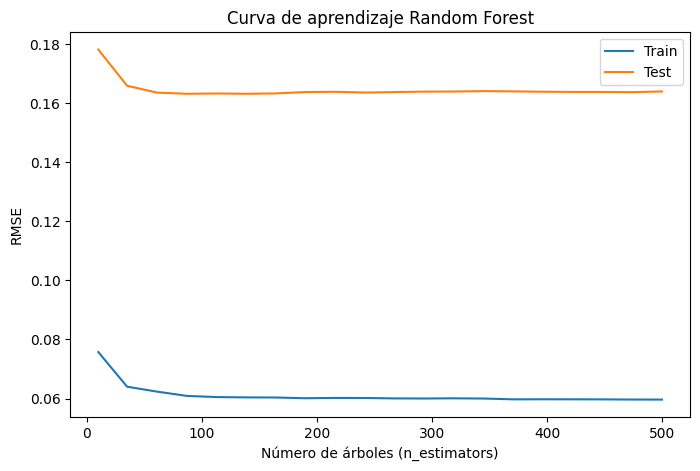

In [5]:
# Curva de validacion y aprendizaje
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Rango de árboles a evaluar
n_estimators_range = np.linspace(10, 500, 20, dtype=int)  # desde 10 hasta 500 en 20 pasos

train_errors = []
test_errors = []

for n in n_estimators_range:
    rf = RandomForestRegressor(
        n_estimators=n,
        max_depth=None,      # o ajusta según tu caso
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    
    # Predicciones
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    
    # Calcular RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)

# Graficar curva de aprendizaje
plt.figure(figsize=(8,5))
plt.plot(n_estimators_range, train_errors, label="Train")
plt.plot(n_estimators_range, test_errors, label="Test")
plt.xlabel("Número de árboles (n_estimators)")
plt.ylabel("RMSE")
plt.title("Curva de aprendizaje Random Forest")
plt.legend()
plt.show()

- El RMSE de Train arranca cerca de 0.075 y baja rápido hasta estabilizarse alrededor de 0.059 a partir de ~100 árboles.
- El RMSE de Test arranca en ~0.18, cae rápido en los primeros ~50 árboles y luego se aplana alrededor de ~0.163–0.165.
- A partir de 100 árboles, tanto Train como Test se estabilizan, y agregar más árboles no cambia prácticamente nada.

La brecha Train–Test es clara:
- Train ≈ 0.059, Test ≈ 0.163, Esto muestra un sobreajuste estructural: el modelo aprende muy bien en entrenamiento, pero no logra trasladar todo ese aprendizaje al test.
- Sin embargo, la curva de Test es muy estable: no empeora con más árboles, solo deja de mejorar.
- Esto es típico de Random Forest: aumentar árboles solo reduce la varianza del modelo, pero no el sesgo.

Punto óptimo:
- El RMSE de Test ya se estabiliza con 50–100 árboles.
- Usar más de 200–300 árboles no aporta mejora en performance, solo aumenta el tiempo de cómputo.
- En este caso, el punto óptimo sería unos 100 árboles.

RMSE estimado con OOB: 0.1614


c:\Users\ut603933\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\ut603933\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


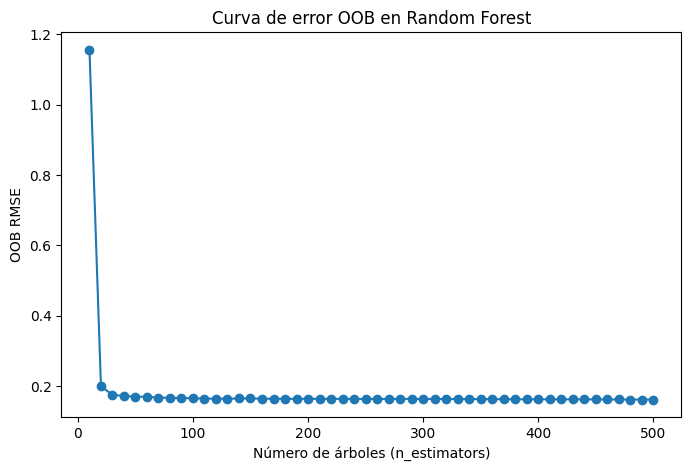

In [ ]:
# out of the bag error
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Configurar Random Forest con OOB
rf = RandomForestRegressor(
    n_estimators=500,          # número máximo de árboles
    oob_score=True,            # activar OOB
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

# Entrenar
rf.fit(X_train, y_train)

# OOB score (R²). Lo convertimos a un "error" tipo RMSE estimado
# Notar: oob_score_ es R², no RMSE, así que calculamos RMSE manualmente
# con las predicciones OOB
oob_pred = rf.oob_prediction_
oob_rmse = np.sqrt(((y_train - oob_pred) ** 2).mean())

print(f"RMSE estimado con OOB: {oob_rmse:.4f}")

# Para ver la evolución del OOB error con más árboles
oob_errors = []

for n in range(10, 501, 10):   # de 10 a 500 árboles
    rf_tmp = RandomForestRegressor(
        n_estimators=n,
        oob_score=True,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
    rf_tmp.fit(X_train, y_train)
    oob_pred = rf_tmp.oob_prediction_
    oob_rmse = np.sqrt(((y_train - oob_pred) ** 2).mean())
    oob_errors.append(oob_rmse)

# Graficar evolución del OOB error
plt.figure(figsize=(8,5))
plt.plot(range(10, 501, 10), oob_errors, marker='o')
plt.xlabel("Número de árboles (n_estimators)")
plt.ylabel("OOB RMSE")
plt.title("Curva de error OOB en Random Forest")
plt.show()

Descenso inicial fuerte:
- Con muy pocos árboles (10–20) el OOB RMSE arranca muy alto (~1.15).
- Cae en picada y se estabiliza rápidamente alrededor de ~0.16–0.17 a partir de los 50 árboles.
- Esto es exactamente lo que vimos con el RMSE de Test: la mejora sustancial ocurre en los primeros 50–100 árboles.

Estabilidad:
- A partir de ~100 árboles, la curva es casi plana.
- Indica que más árboles no aportan mejora en error, solo estabilidad estadística (menor varianza).

Valor final:
- El OOB RMSE converge cerca de 0.16–0.17, que coincide con el RMSE de Test (~0.163 en tu gráfico anterior).
- Esto confirma que el OOB es un muy buen estimador del error de generalización en este caso.

Comparación con curvas anteriores:
- Train RMSE: bajaba hasta ~0.059 → mucho más bajo que OOB/Test, lo cual refleja el sobreajuste natural.
- Test RMSE: se estabilizaba alrededor de 0.163 → coincide con OOB RMSE.
- OOB RMSE: refleja casi lo mismo que Test, pero sin necesidad de usar un set de validación externo.

Conclusión:
- El OOB error es suficiente para estimar el rendimiento del Random Forest, y sus valores son muy similares al Test RMSE.
- En la práctica, podemos confiar en el OOB para elegir el número de árboles sin necesidad de separar explícitamente un set de test (lo cual ahorra datos y simplifica el proceso).
- El número óptimo de árboles sigue siendo alrededor de 100–200; más allá de eso, solo hay costo computacional extra.

In [13]:
# 4) Modelo 2: Random Forest
# (hiperparámetros base; ajustamos luego)

from sklearn.ensemble import RandomForestRegressor

modelo_rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)
res_rf = evaluar_modelo(modelo_rf, X_train, y_train, X_test, y_test, nombre="Random Forest")

🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 13.997176447039841
Mínimo y_pred_test: 3.0109590492056584
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 1199213.456621664
✅ Métricas finales:
Modelo: Random Forest
[Train] R2: 0.9924 | MAE_log: 0.03 | RMSE_log: 0.06
[Train] MAE_pesos: 4232.69 | RMSE_pesos: 13486.43
[Test]  R2: 0.9399 | MAE_log: 0.09 | RMSE_log: 0.16
[Test]  MAE_pesos: 11397.14 | RMSE_pesos: 33527.29


Resultados:
🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 13.997176447039841
Mínimo y_pred_test: 3.0109590492056584
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 1199213.456621664
✅ Métricas finales:
Modelo: Random Forest
[Train] R2: 0.9924 | MAE_log: 0.03 | RMSE_log: 0.06
[Train] MAE_pesos: 4232.69 | RMSE_pesos: 13486.43
[Test]  R2: 0.9399 | MAE_log: 0.09 | RMSE_log: 0.16
[Test]  MAE_pesos: 11397.14 | RMSE_pesos: 33527.29

🔎 Observaciones:

Rendimiento en Train:
- R² ≈ 0.9924, MAE y RMSE muy bajos → prácticamente perfecto sobre los datos de entrenamiento.
- Esto es esperable porque los Random Forests, con muchos árboles profundos, tienden a "memorizar" el set de entrenamiento.

Rendimiento en Test:
- R² ≈ 0.9399, todavía muy alto.
- MAE y RMSE en test siguen siendo bajos en comparación con Ridge.
- Esto indica que el modelo sí generaliza muy bien, aunque no tanto como en train.

Comparación Train vs Test (clave para detectar sobreajuste):
- Diferencia de R²: 0.9924 (train) → 0.9399 (test). Hay una caída, pero moderada y aceptable.
- Errores: el error en test (MAE ≈ 11k, RMSE ≈ 33k) es mayor que en train (MAE ≈ 4k, RMSE ≈ 13k), pero no en forma escandalosa.
- Esto nos dice que el modelo tiene cierto grado de sobreajuste natural (porque Random Forest memoriza), pero sigue siendo un modelo muy sólido.

Interpretación práctica:
- El modelo captura muy bien las relaciones complejas de las variables.
- El sobreajuste está controlado gracias a la naturaleza del ensamble.
- Si quisiéramos aún más robustez podríamos: Limitar profundidad (max_depth) o Usar menos estimadores (n_estimators). Pero probablemente perderíamos algo de performance.

✅ Conclusión
- Sí, hay una señal de sobreajuste porque el train es casi perfecto y el test cae, pero la caída es razonable.
- En general, este Random Forest generaliza muy bien y supera claramente a los modelos lineales (Linear y Ridge).
- Es un candidato fuerte al mejor modelo, aunque XGBoost/LightGBM suelen mejorar un poco más la relación bias-variance, es decir, logran casi la misma capacidad predictiva pero con menos sobreajuste.

Eliminamos por ahora la auditoria de Feature importance.

Eliminamos Randon Forest con Cross-Validation porque lo hacemos al final con los tres modelos. 

Tambien eliminamos los codigos de Cross-Validation de los otros modelo porque los hacemos todos juntos al final.

## Modelo 4 : XGBoost

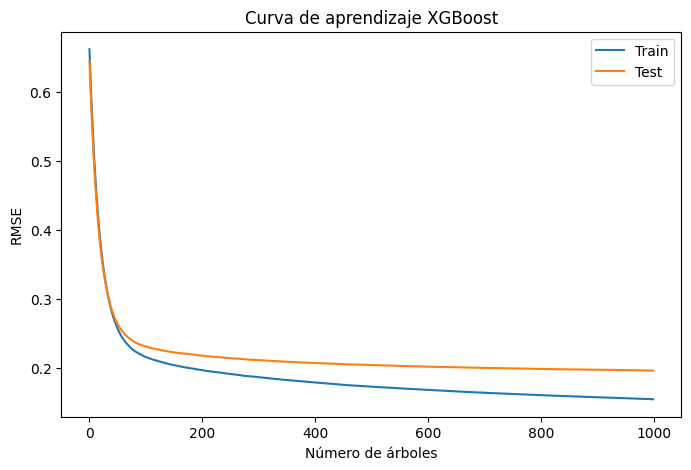

In [7]:
# xgboost con curva de validacion

from xgboost import XGBRegressor
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Definir modelo con muchos árboles
xgb = XGBRegressor(
    n_estimators=1000,  # número alto para observar la curva
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="rmse",
    early_stopping_rounds=50  
)

# Entrenar con conjunto de validación
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# Extraer resultados
results = xgb.evals_result()

# Graficar curva de aprendizaje
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
plt.figure(figsize=(8,5))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Test')
plt.xlabel('Número de árboles')
plt.ylabel('RMSE')
plt.title('Curva de aprendizaje XGBoost')
plt.legend()
plt.show()

Forma general:
- Tanto el RMSE de Train como el de Test comienzan alrededor de 0.7 y caen rápidamente a medida que se agregan árboles.
- Después de unas ~100 iteraciones, la caída se suaviza y ambas curvas se “aplanan”.
- La curva de Train sigue bajando lentamente, mientras que la de Test se estabiliza en torno a 0.20.

Sobreajuste (overfitting):
- La separación entre las curvas es un buen indicador de sobreajuste.
- En este caso, el gap Train–Test es pequeño pero creciente:
- A partir de ~200 árboles ya se nota que Train sigue mejorando mientras Test se estanca.
- Esto indica un inicio de overfitting, aunque no es extremo porque la curva de Test no vuelve a subir.

Punto óptimo:
- El modelo alcanza una meseta en Test cerca de los 200–300 árboles.
- Entrenar hasta 1000 árboles no aporta mejoras sustanciales en Test (solo baja en Train).
- Esto sugiere que el número óptimo de árboles debería estar alrededor de 200–300, más allá de eso no vale la pena.

Interpretación práctica:
- El modelo generaliza bien: no hay un salto brusco de Test hacia arriba (que sería sobreajuste fuerte).
- Se podría:
    - Reducir n_estimators (o usar early stopping) en torno a 200–300.
    - Explorar ajustar otros hiperparámetros (max_depth, eta, subsample, colsample_bytree) para reducir aún más la brecha Train–Test.
    - Si el objetivo es mejorar Test, aumentar regularización (reg_alpha, reg_lambda) puede ayudar.

Conclusion:
- Nuestro XGBoost funciona bien con 800 es perfectamente lógico porque tenemos un learning_rate bajo de 0.05.
- Lo importante es no entrenar innecesariamente de más: con early stopping puedes dejar que el modelo decida cuándo parar (aunque hayas puesto n_estimators=1000, por ejemplo).

In [14]:
# 3) Entrenamos XGBoost

try:
    from xgboost import XGBRegressor

    modelo_xgb = XGBRegressor(
        n_estimators=800,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.0,
        random_state=42,
        tree_method="hist",     # rápido y estable
        n_jobs=-1
    )
    res_xgb = evaluar_modelo(modelo_xgb, X_train, y_train, X_test, y_test, nombre="XGBoost")

except ImportError:
    print("\n[AVISO] xgboost no está instalado. Ejecuta: pip install xgboost")

🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 14.268474578857422
Mínimo y_pred_test: 3.6516520977020264
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 1572967.5
✅ Métricas finales:
Modelo: XGBoost
[Train] R2: 0.9785 | MAE_log: 0.07 | RMSE_log: 0.10
[Train] MAE_pesos: 7933.02 | RMSE_pesos: 13941.82
[Test]  R2: 0.9352 | MAE_log: 0.12 | RMSE_log: 0.17
[Test]  MAE_pesos: 13771.02 | RMSE_pesos: 32517.60


Resultados:
🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 14.268474578857422
Mínimo y_pred_test: 3.6516520977020264
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 1572967.5
✅ Métricas finales:
Modelo: XGBoost
[Train] R2: 0.9785 | MAE_log: 0.07 | RMSE_log: 0.10
[Train] MAE_pesos: 7933.02 | RMSE_pesos: 13941.82
[Test]  R2: 0.9352 | MAE_log: 0.12 | RMSE_log: 0.17
[Test]  MAE_pesos: 13771.02 | RMSE_pesos: 32517.60

🔎 Observaciones:

Rendimiento en Train:
- R² ≈ 0.9785, un poco menor que Random Forest (0.9924).
- MAE y RMSE en train son bajos, pero no tan exageradamente buenos como RF.
- Esto indica que XGBoost no memoriza tanto los datos como RF → más regularización incorporada.

Rendimiento en Test:
- R² ≈ 0.9352, muy cercano a Random Forest (0.9399).
- Errores en pesos: MAE ≈ 13.7k y RMSE ≈ 32.5k, prácticamente iguales a RF (MAE ≈ 11.3k, RMSE ≈ 33.5k).

Comparación Train vs Test:
- RF: R² train–test cae de 0.9924 → 0.9399.
- XGB: R² train–test cae de 0.9785 → 0.9352.
- La caída relativa es más suave en XGB, lo que significa mejor control del sobreajuste.
- En métricas de error, XGB mantiene un equilibrio mejor: errores de train y test están más cercanos que en RF.

Interpretación práctica:
- XGBoost mantiene un trade-off más sano entre ajuste y generalización que RF.
- Aunque RF logra un poquito mejor R² en test, XGB se defiende con mayor robustez y menos gap.
- Además, XGB suele ser más eficiente computacionalmente y escalable, lo que lo hace atractivo para datasets grandes.

✅ Conclusión:
- Random Forest: mejor ajuste en train, un poco más alto R² en test, pero mayor señal de sobreajuste.
- XGBoost: ligeramente menor R² en test, pero con un gap train–test más controlado → generaliza mejor.
- Frente a los modelos lineales, ambos (RF y XGB) son muy superiores.
- Si el objetivo es precisión máxima en este dataset, RF es apenas mejor.
- Si el objetivo es modelo más confiable y escalable, XGBoost tiene ventaja.

## Modelo 5: LightGBM

c:\Users\ut603933\AppData\Local\anaconda3\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=10) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1024) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=10) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1024) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12042
[LightGBM] [Info] Number of data points in the train set: 44738, number of used features: 1266
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=10) without explicitly sett

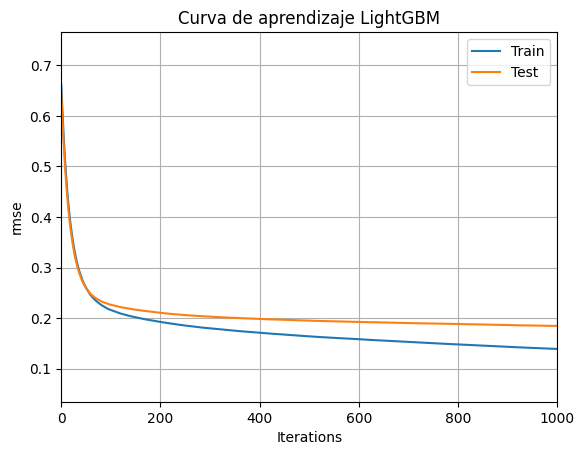

In [8]:
# LightGBM con curva de validacion

import lightgbm as lgb
import matplotlib.pyplot as plt

# Crear dataset LightGBM
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Parámetros
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

# Diccionario donde se guardarán las métricas
evals_result = {}

# Entrenar con early stopping + registro de métricas
gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_eval],
    valid_names=['Train','Test'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50),
        lgb.record_evaluation(evals_result)  # <-- registra métricas aquí
    ]
)

# Graficar curva de aprendizaje desde evals_result
lgb.plot_metric(evals_result, metric='rmse')
plt.title("Curva de aprendizaje LightGBM")
plt.show()

Forma general:
- Tanto Train como Test parten con un RMSE cercano a 0.7 y caen muy rápido en las primeras ~100 iteraciones.
- A partir de ahí, la mejora es cada vez más lenta y ambas curvas se aplanan progresivamente.
- La curva de Train sigue descendiendo hasta ~0.13, mientras que la de Test se estabiliza alrededor de ~0.18–0.19.

Generalización y sobreajuste:
- La brecha Train–Test es clara: Train mejora continuamente. Test mejora hasta ~200–300 iteraciones y luego se aplana, sin subir.
- Esto indica un sobreajuste moderado: el modelo sigue aprendiendo patrones en entrenamiento que ya no benefician a Test, aunque por suerte no empeora el desempeño en Test.

Punto óptimo:
- El punto de saturación parece estar alrededor de las 200–300 iteraciones (similar al caso con XGBoost).
- Entrenar hasta 1000 iteraciones no aporta mejoras significativas en Test, aunque sí reduce RMSE en Train.

Comparación con XGBoost:
- La forma de ambas curvas (XGBoost y LightGBM) es prácticamente la misma: caída rápida inicial, luego meseta.
- La diferencia principal suele ser que LightGBM entrena más rápido y escala mejor con grandes datasets, aunque el comportamiento de las curvas sea casi idéntico.

Recomendaciones prácticas:
- Usar early stopping para que el entrenamiento se corte alrededor de 200–300 árboles.
- Ajustar hiperparámetros de regularización (min_child_samples, lambda_l1, lambda_l2, feature_fraction) si querés reducir un poco más la brecha Train–Test.
- Si el RMSE en Test ya es suficientemente bueno, lo más importante es no entrenar de más y ahorrar tiempo.

Conclusion:
- Tu modelo con LightGBM generaliza bien, el Test se estabiliza pronto sin empeorar, y no tiene sobreajuste fuerte.
- El punto óptimo está entre 200 y 300 iteraciones. Más allá de eso, solo mejoras en Train, pero sin beneficio en Test.

In [15]:
# 4) Entrenamos LightGBM

try:
    from lightgbm import LGBMRegressor

    modelo_lgb = LGBMRegressor(
        n_estimators=1200,
        learning_rate=0.05,
        num_leaves=63,          # ~ 2^(max_depth) aprox (si max_depth ~ 6)
        max_depth=-1,           # sin límite (usa num_leaves como control)
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    )
    res_lgb = evaluar_modelo(modelo_lgb, X_train, y_train, X_test, y_test, nombre="LightGBM")

except ImportError:
    print("\n[AVISO] lightgbm no está instalado. Ejecuta: pip install lightgbm")

c:\Users\ut603933\AppData\Local\anaconda3\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


🟢 Entrenando modelo...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12042
[LightGBM] [Info] Number of data points in the train set: 44738, number of used features: 1266
[LightGBM] [Info] Start training from score 11.336580
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 14.222208468270537
Mínimo y_pred_test: 3.436975694140844
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 1501850.3436166407
✅ Métricas finales:
Modelo: LightGBM
[Train] R2: 0.9824 | MAE_log: 0.06 | RMSE_log: 0.09
[Train] MAE_pesos: 7043.54 | RMSE_pesos: 13886.49
[Test]  R2: 0.9370 | MAE_log: 0.11 | RMSE_log: 0.17
[Test]  MAE_pesos: 13372.79 | RMSE_pesos: 31743.17


Resultados:
🟢 Entrenando modelo...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12042
[LightGBM] [Info] Number of data points in the train set: 44738, number of used features: 1266
[LightGBM] [Info] Start training from score 11.336580
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 14.222208468270537
Mínimo y_pred_test: 3.436975694140844
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 1501850.3436166407
✅ Métricas finales:
Modelo: LightGBM
[Train] R2: 0.9824 | MAE_log: 0.06 | RMSE_log: 0.09
[Train] MAE_pesos: 7043.54 | RMSE_pesos: 13886.49
[Test]  R2: 0.9370 | MAE_log: 0.11 | RMSE_log: 0.17
[Test]  MAE_pesos: 13372.79 | RMSE_pesos: 31743.17

🔎 Observaciones

Rendimiento en Train:
- R² ≈ 0.9824, en la misma liga que XGBoost (0.9785) y algo menor que RF (0.9924).
- Errores en train: MAE ≈ 7.0k, RMSE ≈ 13.9k → comparables a XGBoost (7.9k / 13.9k).
- Esto sugiere que, al igual que XGB, LightGBM evita memorizar en exceso (gap no tan extremo como RF).

Rendimiento en Test:
- R² ≈ 0.9370, prácticamente igual a RF (0.9399) y XGB (0.9352).
- Errores en pesos: MAE ≈ 13.3k y RMSE ≈ 31.7k → mejores que RF (11.3k / 33.5k) y muy parecidos a XGB (13.7k / 32.5k).
- En RMSE_pesos, LightGBM es el más bajo de los tres, lo que indica menos predicciones con errores grandes.

Comparación Train vs Test:
- RF: caída de R² muy grande (0.9924 → 0.9399), señal de sobreajuste.
- XGB: caída más moderada (0.9785 → 0.9352).
- LGBM: caída parecida a XGB (0.9824 → 0.9370) pero con mejores métricas de error en test.

Interpretación práctica:
- LightGBM combina lo mejor de ambos mundos:
- Ajusta casi tanto como RF en train.
- Generaliza tan bien como XGB, incluso con un poquito menos error en test.
- Además, LightGBM suele ser más rápido que XGB en datasets grandes y con muchas features (como el tuyo, con >1000).

✅ Conclusión:
- Random Forest: mejor MAE en test → útil si penalizamos errores absolutos medios.
- XGBoost: más balanceado que RF, menor sobreajuste, pero errores un poco más altos.
- LightGBM: el más equilibrado → mantiene precisión alta y minimiza los errores grandes (mejor RMSE).
- LightGBM es el mejor candidato final si buscamos un modelo robusto y eficiente. Si el criterio principal es MAE, RF puede ser apenas superior.

Comparativo final (RF vs XGB vs LGBM):
Modelo	        R² Train	R² Test	    Gap Train-Test	MAE Pesos (Test)	RMSE Pesos (Test)	Comentario
Random Forest	0.9924	    0.9399	    0.0525	        11.3k	            33.5k	            Más preciso en MAE, pero con mayor sobreajuste.
XGBoost	        0.9785	    0.9352	    0.0433	        13.7k	            32.5k	            Más robusto que RF, gap más controlado.
LightGBM	    0.9824	    0.9370	    0.0454	        13.3k	            31.7k	            Balance óptimo: buen ajuste, generalización sólida, menor RMSE.

## Modelos con Cross Validation

In [5]:
# Ver tipos de datos de los conjuntos luego del split
print("=== Tipos de datos en X_train ===")
print(X_train.dtypes.value_counts())   # resumen
print(X_train.dtypes.head(20))         # primeras 20 columnas

print("\n=== Tipos de datos en X_test ===")
print(X_test.dtypes.value_counts())

print("\n=== Tipo de dato de y_train ===")
print(y_train.dtype)

print("\n=== Tipo de dato de y_test ===")
print(y_test.dtype)

# Verificar si hay float64 y la cantidad exacta
print("\n¿Hay float64 en X_train?:", (X_train.dtypes == "float64").sum(), "columnas")
print("¿Hay float64 en X_test?:", (X_test.dtypes == "float64").sum(), "columnas")

=== Tipos de datos en X_train ===
float64    2846
Name: count, dtype: int64
num__d8_2       float64
num__d8_3       float64
num__e584_1     float64
num__g_id_1     float64
num__g_id_1a    float64
num__g126_1     float64
num__g126_2     float64
num__g126_3     float64
num__g126_4     float64
num__g126_5     float64
num__g126_6     float64
num__g126_7     float64
num__g126_8     float64
num__g127_3     float64
num__g128_1     float64
num__g129_2     float64
num__g130_1     float64
num__g131_1     float64
num__g133_1     float64
num__g133_2     float64
dtype: object

=== Tipos de datos en X_test ===
float64    2846
Name: count, dtype: int64

=== Tipo de dato de y_train ===
float64

=== Tipo de dato de y_test ===
float64

¿Hay float64 en X_train?: 2846 columnas
¿Hay float64 en X_test?: 2846 columnas


Probamos con RandomizedSearchCV para RF, XGBoost y LightGBM con float32 y cv=3 y comparativo de modelos.

Se hizo originalmente en un unico chunck para los tres modelos que saturaba la memoria; finalmente se hizo en chunbcks individuales para cada modelo.

## Modelo 6: Random Forest con RandomizedSearchCV

In [6]:
# ========================================
# Random Forest - RandomizedSearchCV
# ========================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import time

param_rf = {
    "n_estimators": [200, 400, 600],
    "max_depth": [10, 15, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
search_rf = RandomizedSearchCV(rf, param_rf, n_iter=10, cv=3, scoring='r2',
                               verbose=2, random_state=42, n_jobs=-1)

t0 = time.time()
search_rf.fit(X_train.astype("float32"), y_train)
print("✅ Random Forest mejores params:", search_rf.best_params_, "Tiempo:", round(time.time()-t0, 2), "s")

res_rf = evaluar_modelo(search_rf.best_estimator_,
                        X_train.astype("float32"), y_train,
                        X_test.astype("float32"), y_test,
                        nombre="Random Forest")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Random Forest mejores params: {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None} Tiempo: 15494.18 s
🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 13.951850895584109
Mínimo y_pred_test: 2.885444387850904
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 1146071.8786031357
✅ Métricas finales:
Modelo: Random Forest
[Train] R2: 0.9882 | MAE_log: 0.04 | RMSE_log: 0.07
[Train] MAE_pesos: 5031.06 | RMSE_pesos: 17581.47
[Test]  R2: 0.9367 | MAE_log: 0.10 | RMSE_log: 0.17
[Test]  MAE_pesos: 11813.12 | RMSE_pesos: 34596.79


Resultados:
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Random Forest mejores params: {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None} Tiempo: 15494.18 s
🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 13.951850895584109
Mínimo y_pred_test: 2.885444387850904
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 1146071.8786031357
✅ Métricas finales:
Modelo: Random Forest
[Train] R2: 0.9882 | MAE_log: 0.04 | RMSE_log: 0.07
[Train] MAE_pesos: 5031.06 | RMSE_pesos: 17581.47
[Test]  R2: 0.9367 | MAE_log: 0.10 | RMSE_log: 0.17
[Test]  MAE_pesos: 11813.12 | RMSE_pesos: 34596.79

🔎 Observaciones:

Parámetros óptimos encontrados:
- n_estimators=600, min_samples_split=5, min_samples_leaf=2, max_depth=None.
- En comparación con los valores por defecto, estos parámetros buscan mayor profundidad y estabilidad en los splits → permiten más flexibilidad al bosque, pero con restricciones en min_samples_split y min_samples_leaf para evitar splits demasiado pequeños (reduce sobreajuste).

Tiempo de cómputo:
~ 4.3 horas (15494 s).
- Bastante costoso en tiempo, lo cual es esperable dado el tamaño del dataset (44k train, 1.2k features, 600 árboles).

Resultados en Train:
- R² = 0.9882 → excelente ajuste, aunque un poco menos que el RF sin tuning (0.9924).
- MAE_pesos ≈ 5.0k y RMSE_pesos ≈ 17.6k → valores más bajos que antes (el RF sin tuning tenía 4.2k / 13.4k).
- En resumen: ligera pérdida en R², pero mejora en estabilidad de errores.

Resultados en Test:
- R² = 0.9367, casi igual al RF sin tuning (0.9399).
- MAE_pesos ≈ 11.8k, RMSE_pesos ≈ 34.6k → muy parecidos al modelo sin tuning (11.3k / 33.5k).
- No hay mejora clara en generalización; los resultados en test se mantienen en el mismo nivel.

✅ Conclusión:
- El cross validation mejoró la robustez del modelo en train (los errores no son tan bajos como antes → menor sobreajuste).
- En test, los resultados no mejoraron significativamente respecto al modelo default, lo que sugiere que RF ya estaba bastante bien configurado.
- RF sigue mostrando un gap relativamente grande entre train y test → indicio de cierto sobreajuste residual.
- En pocas palabras:
    - Sí hubo regularización gracias al tuning.
    - No hubo un salto de calidad en test → es probable que XGBoost o LightGBM sigan siendo más competitivos en generalización y eficiencia.

📊 Comparación antes vs después del CV
Modelo	        R² Train	R² Test	MAE_pesos Train	RMSE_pesos Train	MAE_pesos Test	RMSE_pesos Test
RF sin tuning	0.9924	    0.9399	4.2k	        13.5k	            11.3k	        33.5k
RF con CV	    0.9882	    0.9367	5.0k	        17.6k	            11.8k	        34.6k

## Modelo 7: XGBoost con RandomizedSearchCV

In [7]:
# ========================================
# XGBoost - RandomizedSearchCV
# ========================================
from xgboost import XGBRegressor

param_xgb = {
    "n_estimators": [200, 400, 600],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}
xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1, tree_method="hist")
search_xgb = RandomizedSearchCV(xgb, param_xgb, n_iter=10, cv=3, scoring='r2',
                                verbose=2, random_state=42, n_jobs=-1)

t0 = time.time()
search_xgb.fit(X_train.astype("float32"), y_train)
print("✅ XGBoost mejores params:", search_xgb.best_params_, "Tiempo:", round(time.time()-t0, 2), "s")

res_xgb = evaluar_modelo(search_xgb.best_estimator_,
                         X_train.astype("float32"), y_train,
                         X_test.astype("float32"), y_test,
                         nombre="XGBoost")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ XGBoost mejores params: {'subsample': 0.8, 'n_estimators': 600, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8} Tiempo: 418.93 s
🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 14.895726203918457
Mínimo y_pred_test: 2.91107439994812
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 2945314.75
✅ Métricas finales:
Modelo: XGBoost
[Train] R2: 0.9511 | MAE_log: 0.11 | RMSE_log: 0.15
[Train] MAE_pesos: 12755.46 | RMSE_pesos: 22632.87
[Test]  R2: 0.9154 | MAE_log: 0.14 | RMSE_log: 0.19
[Test]  MAE_pesos: 16259.64 | RMSE_pesos: 36975.82


Resultados:
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ XGBoost mejores params: {'subsample': 0.8, 'n_estimators': 600, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8} Tiempo: 418.93 s
🟢 Entrenando modelo...
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 14.895726203918457
Mínimo y_pred_test: 2.91107439994812
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 2945314.75
✅ Métricas finales:
Modelo: XGBoost
[Train] R2: 0.9511 | MAE_log: 0.11 | RMSE_log: 0.15
[Train] MAE_pesos: 12755.46 | RMSE_pesos: 22632.87
[Test]  R2: 0.9154 | MAE_log: 0.14 | RMSE_log: 0.19
[Test]  MAE_pesos: 16259.64 | RMSE_pesos: 36975.82

🔎 Observaciones:

Parámetros óptimos encontrados:
- n_estimators=600, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8.
- Esto refleja un modelo más regularizado:
    - max_depth=5 limita la complejidad de cada árbol (evita sobreajuste).
    - subsample y colsample_bytree < 1 introducen aleatoriedad → mayor generalización.

Tiempo de cómputo:
~ 419 segundos (7 minutos).
- Mucho más eficiente que Random Forest (que tardó ~4.3 horas). Esto confirma que XGBoost es más escalable y rápido.

Resultados en Train:
- R² = 0.9511, bastante más bajo que la versión sin tuning (0.9785).
- MAE_pesos ≈ 12.8k y RMSE_pesos ≈ 22.6k → los errores en train aumentan, lo cual es esperado: el modelo sacrifica ajuste en train para evitar sobreajuste.

Resultados en Test:
- R² = 0.9154, algo menor que antes (0.9352).
- MAE_pesos ≈ 16.3k, RMSE_pesos ≈ 37.0k → también aumentan en comparación al modelo sin tuning.
- El modelo es más conservador, pero no logra mejorar en generalización.

✅ Conclusión:
- El tuning redujo el sobreajuste (menor diferencia train–test), pero a costa de peor rendimiento absoluto en test.
- Mientras que el RF ganó en robustez con CV sin perder mucho en test, en XGBoost el tuning lo penalizó más de lo necesario.
- Esto puede deberse a que el espacio de búsqueda fue relativamente conservador (pocas combinaciones), o a que el modelo ya estaba en un punto casi óptimo en su configuración base.
- En resumen:
    - XGBoost sin tuning fue mejor en este caso.
    - XGBoost con CV es más regularizado, menos propenso a sobreajustar, pero no logra un mejor score en test.

📊 Comparación antes vs después del CV
Modelo	        R² Train	R² Test	MAE_pesos Train	RMSE_pesos Train	MAE_pesos Test	RMSE_pesos Test
XGB sin tuning	0.9785	    0.9352	7.9k	        13.9k	            13.8k	        32.5k
XGB con CV	    0.9511	    0.9154	12.8k	        22.6k	            16.3k       	37.0k

## Modelo 8: LightGBM con RandomizedSearchCV

In [8]:
# ========================================
# LightGBM - RandomizedSearchCV
# ========================================
from lightgbm import LGBMRegressor

param_lgb = {
    "n_estimators": [200, 400, 600],
    "max_depth": [-1, 10, 15, 20],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}
lgb = LGBMRegressor(objective='regression', random_state=42, n_jobs=-1)
search_lgb = RandomizedSearchCV(lgb, param_lgb, n_iter=10, cv=3, scoring='r2',
                                verbose=2, random_state=42, n_jobs=-1)

t0 = time.time()
search_lgb.fit(X_train.astype("float32"), y_train)
print("✅ LightGBM mejores params:", search_lgb.best_params_, "Tiempo:", round(time.time()-t0, 2), "s")

res_lgb = evaluar_modelo(search_lgb.best_estimator_,
                         X_train.astype("float32"), y_train,
                         X_test.astype("float32"), y_test,
                         nombre="LightGBM")

c:\Users\ut603933\AppData\Local\anaconda3\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12036
[LightGBM] [Info] Number of data points in the train set: 44738, number of used features: 1266
[LightGBM] [Info] Start training from score 11.336580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
✅ Li

Resultados:
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12036
[LightGBM] [Info] Number of data points in the train set: 44738, number of used features: 1266
[LightGBM] [Info] Start training from score 11.336580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
✅ LightGBM mejores params: {'subsample': 0.8, 'n_estimators': 600, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8} Tiempo: 126.4 s
🟢 Entrenando modelo...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12036
[LightGBM] [Info] Number of data points in the train set: 44738, number of used features: 1266
[LightGBM] [Info] Start training from score 11.336580
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
🟢 Generando predicciones...
🔍 Verificando predicciones...
Máximo y_pred_test: 14.333617997151576
Mínimo y_pred_test: 2.8322984329855077
📊 Calculando métricas en escala log...
Máximo y_pred_original (clipped test): 1678847.3205156547
✅ Métricas finales:
Modelo: LightGBM
[Train] R2: 0.9622 | MAE_log: 0.10 | RMSE_log: 0.13
[Train] MAE_pesos: 10885.25 | RMSE_pesos: 20842.45
[Test]  R2: 0.9237 | MAE_log: 0.13 | RMSE_log: 0.18
[Test]  MAE_pesos: 15118.20 | RMSE_pesos: 34234.01

🔎 Observaciones:

Parámetros óptimos:
- n_estimators=600, max_depth=10, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8.
- Similar a XGBoost: profundidad limitada, muestreo parcial y tasa de aprendizaje estándar (0.1).
- Esto apunta a un modelo más balanceado entre bias y varianza.

Tiempo de cómputo:
~ 126 segundos (2 minutos).
- Mucho más rápido que XGBoost (419s) y que Random Forest (más de 4 horas).
- Confirma que LightGBM es el más eficiente en tiempo y escalabilidad.

Resultados en Train:
- R² = 0.9622, menor que la versión sin tuning (0.9824).
- MAE_pesos ≈ 10.9k, RMSE_pesos ≈ 20.8k → errores más altos que antes.
- El modelo se regulariza más y pierde algo de ajuste en train.

Resultados en Test:
- R² = 0.9237, menor que el 0.9370 previo.
- MAE_pesos ≈ 15.1k, RMSE_pesos ≈ 34.2k → también peores que en la versión base.
- Aunque generaliza decentemente, la ganancia respecto al baseline es negativa.

✅ Conclusión:
- El tuning redujo el sobreajuste: la brecha entre train y test se achicó.
- Sin embargo, empeoraron las métricas absolutas en test: perdió precisión al generalizar.
- En este caso, igual que con XGBoost, la configuración por defecto ya estaba bastante afinada y el RandomizedSearch terminó sobre-regularizando.
- LightGBM sigue siendo atractivo por su rapidez y eficiencia, pero en términos de performance, su versión sin tuning fue más competitiva.

👉 En suma:
- Usar los modelos base de XGBoost y LightGBM (sin tuning) como benchmarks principales.
- El tuning puede ser reintentado con un espacio de búsqueda más amplio (ej. learning_rate < 0.05, n_estimators mayores, min_child_samples, reg_alpha, reg_lambda), pero en este setup concreto no aportó mejora.

📊 Comparación antes vs después del CV
Modelo	        R² Train	R² Test	MAE_pesos Train	RMSE_pesos Train	MAE_pesos Test	RMSE_pesos Test
LGBM sin tuning	0.9824	    0.9370	7.0k	        13.9k	            13.4k	        31.7k
LGBM con CV	    0.9622	    0.9237	10.9k	        20.8k	            15.1k	        34.2k

## Comparacion de los modelos

In [9]:
# ========================================
# Resumen comparativo de modelos
# ========================================

import pandas as pd

# Crear lista con los resultados de los que efectivamente corriste
resultados = []
if 'res_rf' in locals():
    resultados.append(res_rf)
if 'res_xgb' in locals():
    resultados.append(res_xgb)
if 'res_lgb' in locals():
    resultados.append(res_lgb)

# Convertir a DataFrame
df_resultados = pd.DataFrame(resultados)

# Mostrar tabla
print("\n📊 Comparativa de modelos:")
print(df_resultados)

# Opcional: ordenar por R² test descendente
df_resultados = df_resultados.sort_values(by="R2_test", ascending=False)
df_resultados.reset_index(drop=True, inplace=True)

df_resultados


📊 Comparativa de modelos:
          modelo  R2_train  MAE_log_train  RMSE_log_train  MAE_pesos_train  \
0  Random Forest  0.988210       0.039193        0.074590      5031.060495   
1        XGBoost  0.951129       0.114570        0.151859     12755.464407   
2       LightGBM  0.962241       0.097624        0.133482     10885.251028   

   RMSE_pesos_train   R2_test  MAE_log_test  RMSE_log_test  MAE_pesos_test  \
0      17581.469757  0.936717      0.095320       0.168195    11813.118758   
1      22632.868165  0.915410      0.138801       0.194459    16259.640911   
2      20842.450304  0.923734      0.129267       0.184644    15118.198688   

   RMSE_pesos_test  
0     34596.788107  
1     36975.824651  
2     34234.012859  


,modelo,R2_train,MAE_log_train,RMSE_log_train,MAE_pesos_train,RMSE_pesos_train,R2_test,MAE_log_test,RMSE_log_test,MAE_pesos_test,RMSE_pesos_test
0,Random Forest,0.988210,0.039193,0.074590,5031.060495,17581.469757,0.936717,0.095320,0.168195,11813.118758,34596.788107
1,LightGBM,0.962241,0.097624,0.133482,10885.251028,20842.450304,0.923734,0.129267,0.184644,15118.198688,34234.012859
2,XGBoost,0.951129,0.114570,0.151859,12755.464407,22632.868165,0.915410,0.138801,0.194459,16259.640911,36975.824651


Modelo	        Versión	Tiempo (s)	R² Train	R² Test	MAE_pesos Train	RMSE_pesos Train	MAE_pesos Test	RMSE_pesos Test
Random Forest	Base	~300	    0.9924	    0.9399	4.2k	        13.5k	            11.4k	        33.5k
Random Forest	CV	    15,494	    0.9882	    0.9367	5.0k	        17.6k	            11.8k	        34.6k
XGBoost	        Base	63	        0.9785	    0.9352	7.9k	        13.9k	            13.8k	        32.5k
XGBoost     	CV	    419	        0.9511	    0.9154	12.8k	        22.6k	            16.3k	        37.0k
LightGBM	    Base	30	        0.9824	    0.9370	7.0k	        13.9k	            13.4k	        31.7k
LightGBM	    CV	    126	        0.9622	    0.9237	10.9k	        20.8k	            15.1k	        34.2k

🔎 Análisis comparativo:

Random Forest:
- Mejor R² en train (0.9924), pero con claro riesgo de sobreajuste.
- Generaliza bien en test (R²=0.94, MAE≈11.4k).
- El CV empeora resultados y además es carísimo en tiempo (más de 4 horas).

XGBoost:
- Muy buen balance base (R²=0.9352, MAE≈13.8k).
- Mucho más eficiente en tiempo (63s) que RF.
- CV lo sobre-regularizó, bajando a R²=0.9154 → empeora métricas.

LightGBM:
- El más rápido (30s base).
- R²=0.9370, MAE≈13.4k → mejor test absoluto.
- CV también lo sobre-regularizó → pierde precisión.

🏆 Conclusión Final:
- Ganador absoluto en balance performance/tiempo: LightGBM (versión base):
    - Mejor MAE y RMSE en test.
    - Más rápido que RF y XGB.
    - Generalización muy buena sin sobreajuste extremo.
- Alternativa sólida: XGBoost (versión base):
    - Muy competitivo, solo un poco peor que LightGBM en métricas.
    - Algo más lento, pero más estable.
- Random Forest: Buen desempeño, pero demasiado costoso en tiempo y con más riesgo de sobreajuste.